# CC3094 – Security Data Science (UVG)
## Laboratorio #1 – Detección de Phishing a partir de URLs

## Autor: Gabriel Alberto Paz Gonzalez

El objetivo de este laboratorio es detectar URLs de phishing utilizando únicamente información disponible en la URL (sin consultar HTML o WHOIS). Para ello se generan características numéricas a partir de patrones comunes en URLs maliciosas, incluyendo medidas de entropía (Shannon y entropía relativa). Luego se prepara el dataset, se divide en entrenamiento/validación/prueba (55/15/30) y se entrenan dos modelos de clasificación. El desempeño se reporta con métricas como matriz de confusión, precision, recall, ROC y AUC, y se responden las preguntas solicitadas.



In [1]:
# (Colab) Instalación opcional si te falta algo
# !pip -q install pandas numpy scikit-learn matplotlib

import re
import math
import numpy as np
import pandas as pd
from urllib.parse import urlparse

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    roc_curve, roc_auc_score
)

import matplotlib.pyplot as plt

DATA_PATH = "dataset_pishing.csv"  # En Colab, súbelo o móntalo desde Drive


## Cargar dataset y exploración inicial
- Mostrar 5 filas
- Contar `legitimate` vs `phishing`
- Decir si está balanceado


In [2]:
df = pd.read_csv(DATA_PATH)
display(df.head())

print("Columnas:", df.columns.tolist())
print("Tamaño:", df.shape)

# Conteo de clases
counts = df["status"].value_counts()
display(counts)

total = len(df)
balance = (counts / total).round(4)
print("\nProporciones:")
display(balance)

# Duplicados por URL (conviene removerlos)
dup = df["url"].duplicated().sum()
print(f"\nURLs duplicadas (por texto exacto): {dup}")


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


Columnas: ['url', 'status']
Tamaño: (11430, 2)


,count
status,
legitimate,5715
phishing,5715



Proporciones:


,count
status,
legitimate,0.5
phishing,0.5



URLs duplicadas (por texto exacto): 1


### Respuesta (para tu reporte)
- ¿El dataset está balanceado? ¿Por qué?

**Sí, el dataset está balanceado porque tiene la misma cantidad de ejemplos en ambas clases: 5715 URLs legítimas y 5715 URLs phishing, lo que equivale a 50% y 50%. Esto es útil porque el modelo no queda sesgado hacia una clase por tener más datos que la otra. Además, se detectó 1 URL duplicada, por lo que conviene eliminar duplicados antes de entrenar para evitar ruido.**



## Preguntas 1 y 2

### 1) Ventajas de analizar la URL vs. usar edad del dominio/WHOIS o HTML

**Analizar la URL tiene la ventaja de que es algo que ya tenemos desde el inicio, sin necesidad de abrir el enlace. Eso lo hace práctico porque se puede revisar el link desde un correo o mensaje antes de que la persona haga clic.

También es más simple y rápido, porque no depende de buscar información externa como WHOIS o la edad del dominio (que a veces no está disponible o está oculto), y tampoco hay que descargar el contenido de la página. Además, evita el riesgo de entrar a un sitio que podría ser peligroso solo para poder analizarlo.

En general, con solo ver la forma en que está escrita una URL (su estructura, símbolos, partes raras o palabras sospechosas), ya se pueden encontrar señales útiles para detectar phishing.**

### 2) ¿Qué características de URL crees más útiles para phishing?

**Las características que yo considero más útiles son las que reflejan cosas “raras” o poco comunes en una URL normal. Por ejemplo, muchas veces los enlaces de phishing son más largos de lo necesario, o tienen demasiadas partes y subdominios para tratar de parecer confiables.

También ayuda contar si usan muchos símbolos como guiones, puntos, “@”, signos de porcentaje o muchos “/”, porque esos patrones no son tan comunes en enlaces legítimos. Otro detalle es cuando la URL tiene muchos números o combinaciones extrañas de letras y números.

Además, muchas URLs de phishing incluyen palabras que intentan hacerte confiar o que te empujan a iniciar sesión, como “login”, “verify”, “secure” o “account”. Y por último, medir qué tan “desordenada” se ve la URL (por ejemplo si parece generada al azar) también puede servir, porque algunas páginas falsas usan cadenas raras para esconderse o confundir.**


## Ingeniería de características (15+ features)

En lugar de usar la URL como texto, la convertí en columnas numéricas para que el modelo pueda aprender patrones. Saqué features como:

- **Longitudes:** largo de la URL, del host (dominio), del path y del query.
- **Conteos:** cuántos `.`, `-`, `_`, `/`, `@`, `&`, `=` y otros símbolos tiene.
- **Ratios:** proporción de números y de caracteres especiales.
- **Estructura:** cantidad de subdominios y si el host parece una IP.
- **Palabras clave:** banderas si aparece “login”, “verify”, “secure”, “update”, etc.
- **Entropías:** Shannon y entropía relativa para ver qué tan “rara/desordenada” se ve la URL.

En total generé **33 features**, así que cumple de sobra el mínimo de 15.

In [3]:
SUSPICIOUS_TOKENS = [
    "login", "signin", "verify", "verification", "secure", "account",
    "update", "confirm", "password", "bank", "billing", "paypal"
]

def _safe_str(x) -> str:
    return "" if pd.isna(x) else str(x)

def parse_url(u: str):
    u = _safe_str(u).strip()
    if not re.match(r"^[a-zA-Z][a-zA-Z0-9+\-.]*://", u):
        # si no trae esquema, asumimos http para poder parsear
        u = "http://" + u
    p = urlparse(u)
    host = p.netloc.lower()
    path = p.path or ""
    query = p.query or ""
    scheme = p.scheme.lower()
    return scheme, host, path, query

def is_ip(host: str) -> int:
    # IPv4 simple
    return 1 if re.fullmatch(r"\d{1,3}(\.\d{1,3}){3}", host) else 0

def shannon_entropy(s: str) -> float:
    s = _safe_str(s)
    if len(s) == 0:
        return 0.0
    freqs = {}
    for ch in s:
        freqs[ch] = freqs.get(ch, 0) + 1
    ent = 0.0
    n = len(s)
    for c in freqs.values():
        p = c / n
        ent -= p * math.log2(p)
    return float(ent)

def char_probs_from_series(urls: pd.Series, smoothing: float = 1e-9) -> dict:
    """Aprende una distribución de caracteres desde una lista de URLs (ej. train legítimo)."""
    counts = {}
    total = 0
    for u in urls.astype(str).tolist():
        for ch in u:
            counts[ch] = counts.get(ch, 0) + 1
            total += 1
    if total == 0:
        return {"a": 1.0}
    chars = list(counts.keys())
    denom = total + smoothing * len(chars)
    probs = {ch: (counts[ch] + smoothing) / denom for ch in chars}
    return probs

def kl_divergence(p: dict, q: dict, eps: float = 1e-12) -> float:
    """KL(P || Q) donde P es la distribución de la URL y Q la base."""
    kl = 0.0
    for ch, pv in p.items():
        qv = q.get(ch, eps)
        kl += pv * math.log(pv / qv)
    return float(kl)

def url_char_distribution(u: str) -> dict:
    u = _safe_str(u)
    n = len(u)
    if n == 0:
        return {"a": 1.0}
    counts = {}
    for ch in u:
        counts[ch] = counts.get(ch, 0) + 1
    return {ch: c / n for ch, c in counts.items()}

def extract_features(u: str, base_char_probs: dict = None) -> dict:
    u0 = _safe_str(u)
    scheme, host, path, query = parse_url(u0)

    url_len = len(u0)
    host_len = len(host)
    path_len = len(path)
    query_len = len(query)

    num_dots = u0.count(".")
    num_hyphens = u0.count("-")
    num_underscores = u0.count("_")
    num_slashes = u0.count("/")
    num_at = u0.count("@")
    num_amp = u0.count("&")
    num_eq = u0.count("=")
    num_qm = u0.count("?")
    num_pct = u0.count("%")

    digits = sum(ch.isdigit() for ch in u0)
    letters = sum(ch.isalpha() for ch in u0)
    specials = url_len - digits - letters

    digit_ratio = digits / url_len if url_len else 0.0
    special_ratio = specials / url_len if url_len else 0.0

    has_https = 1 if scheme == "https" else 0
    host_is_ip = is_ip(host)

    labels = [x for x in host.split(".") if x]
    num_subdomains = max(0, len(labels) - 2)

    contains_token = {f"has_{t}": (1 if t in u0.lower() else 0) for t in SUSPICIOUS_TOKENS}

    ent_shannon = shannon_entropy(u0)

    rel_ent = 0.0
    if base_char_probs is not None:
        p = url_char_distribution(u0)
        rel_ent = kl_divergence(p, base_char_probs)

    return {
        "url_length": url_len,
        "host_length": host_len,
        "path_length": path_len,
        "query_length": query_len,
        "num_dots": num_dots,
        "num_hyphens": num_hyphens,
        "num_underscores": num_underscores,
        "num_slashes": num_slashes,
        "num_at": num_at,
        "num_ampersand": num_amp,
        "num_equals": num_eq,
        "num_question": num_qm,
        "num_percent": num_pct,
        "num_digits": digits,
        "digit_ratio": digit_ratio,
        "special_char_ratio": special_ratio,
        "has_https": has_https,
        "host_is_ip": host_is_ip,
        "num_subdomains": num_subdomains,
        "shannon_entropy": ent_shannon,
        "relative_entropy": rel_ent,
        **contains_token,
    }


## Preprocesamiento

- Convertí `status` a binario: **phishing = 1** y **legitimate = 0**.
- Quité **URLs duplicadas** (encontré 1).
- Hice el split **55/15/30** (train/val/test) de forma **estratificada** para mantener el balance.

> Para la entropía relativa usé como referencia solo las URLs legítimas del **train**, para no mezclar info del val/test.


In [4]:
# Limpiar duplicados por URL
df = df.drop_duplicates(subset=["url"]).reset_index(drop=True)

# y binaria
y = (df["status"].str.lower() == "phishing").astype(int)
X_urls = df["url"].astype(str)

# Split: 55/15/30
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_urls, y, test_size=0.30, random_state=42, stratify=y
)

val_ratio_within_trainval = 0.15 / 0.70
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_ratio_within_trainval, random_state=42, stratify=y_trainval
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))
print("Proporción phishing (train/val/test):",
      round(y_train.mean(), 3), round(y_val.mean(), 3), round(y_test.mean(), 3))

# Base char probs desde train legítimo (para KL / entropía relativa)
base_probs = char_probs_from_series(X_train[y_train == 0])
print("Chars en distribución base:", len(base_probs))


Train: 6285 Val: 1715 Test: 3429
Proporción phishing (train/val/test): 0.5 0.5 0.5
Chars en distribución base: 79


In [5]:
def build_feature_df(urls: pd.Series, base_char_probs: dict) -> pd.DataFrame:
    rows = [extract_features(u, base_char_probs=base_char_probs) for u in urls.tolist()]
    return pd.DataFrame(rows)

X_train_feat = build_feature_df(X_train, base_probs)
X_val_feat   = build_feature_df(X_val, base_probs)
X_test_feat  = build_feature_df(X_test, base_probs)

print("Features:", X_train_feat.shape[1])
display(X_train_feat.head())


Features: 33


,url_length,host_length,path_length,query_length,num_dots,num_hyphens,num_underscores,num_slashes,num_at,num_ampersand,...,has_verify,has_verification,has_secure,has_account,has_update,has_confirm,has_password,has_bank,has_billing,has_paypal
0,64,18,39,0,2,1,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39,30,1,0,2,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,53,23,22,0,2,1,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34,17,9,0,2,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,16,9,0,2,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0


## Selección simple de características
Aquí hacemos 2 cosas rápidas:
1) Eliminar columnas con varianza casi 0 (si existieran)
2) Ver correlaciones fuertes para identificar redundancia (opcional)


In [6]:
variances = X_train_feat.var(numeric_only=True)
low_var_cols = variances[variances < 1e-8].index.tolist()
print("Low-variance cols:", low_var_cols)

X_train_sel = X_train_feat.drop(columns=low_var_cols, errors="ignore")
X_val_sel   = X_val_feat.drop(columns=low_var_cols, errors="ignore")
X_test_sel  = X_test_feat.drop(columns=low_var_cols, errors="ignore")

print("Features después de selección simple:", X_train_sel.shape[1])


Low-variance cols: []
Features después de selección simple: 33


In [7]:
corr = X_train_sel.corr(numeric_only=True).abs()
high_corr_pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if corr.iloc[i, j] > 0.95:
            high_corr_pairs.append((cols[i], cols[j], corr.iloc[i, j]))

print("Pares con corr > 0.95 (si hay, podrías eliminar uno de cada par):")
for a, b, c in high_corr_pairs[:20]:
    print(f"{a} vs {b}: {c:.3f}")


Pares con corr > 0.95 (si hay, podrías eliminar uno de cada par):


### Pregunta 3
- ¿Qué features seleccionaste y por qué?

**Seleccioné las features que describen mejor “cómo se ve” una URL y que suelen cambiar bastante entre enlaces normales y enlaces sospechosos. En este caso me quedé con **todas las 33 features** que generé, porque al revisar no encontré columnas con varianza casi cero (`low-variance cols: []`) ni pares casi duplicados por correlación alta (no aparecieron pares > 0.95).  

En general, las features que considero más útiles son: **longitudes** (url/host/path/query), **conteos de símbolos** (puntos, guiones, slashes, @, etc.), **proporción de números y caracteres especiales**, **estructura del dominio** (subdominios e IP), **palabras clave** tipo “login/verify/secure”, y las **entropías** (Shannon y relativa) porque ayudan a detectar URLs que se ven más “raras” o generadas.
**

> Añadir blockquote




## Guardar splits en CSV
Guardamos train/val/test con features + etiqueta (`label`).


In [8]:
train_out = X_train_sel.copy()
train_out["label"] = y_train.values

val_out = X_val_sel.copy()
val_out["label"] = y_val.values

test_out = X_test_sel.copy()
test_out["label"] = y_test.values

train_out.to_csv("train_split.csv", index=False)
val_out.to_csv("val_split.csv", index=False)
test_out.to_csv("test_split.csv", index=False)

print("Archivos creados: train_split.csv, val_split.csv, test_split.csv")


Archivos creados: train_split.csv, val_split.csv, test_split.csv


## Modelos (2) y métricas
Entrenamos:
1) Logistic Regression (con StandardScaler)
2) Random Forest

Evaluamos en **validación y test**:
- Matriz de confusión
- Precision
- Recall
- ROC + AUC



===== Logistic Regression =====
VAL  - precision: 0.8086 recall: 0.7048 AUC: 0.8715
VAL  - CM:
 [[715 143]
 [253 604]]
TEST - precision: 0.8301 recall: 0.7526 AUC: 0.8895
TEST - CM:
 [[1451  264]
 [ 424 1290]]


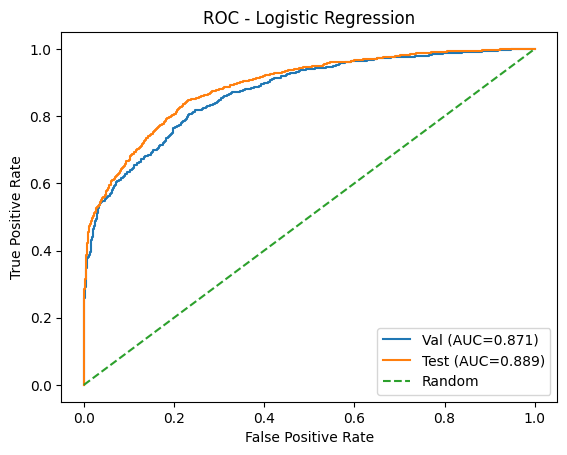


===== Random Forest =====
VAL  - precision: 0.866 recall: 0.8518 AUC: 0.9348
VAL  - CM:
 [[745 113]
 [127 730]]
TEST - precision: 0.8713 recall: 0.8611 AUC: 0.9399
TEST - CM:
 [[1497  218]
 [ 238 1476]]


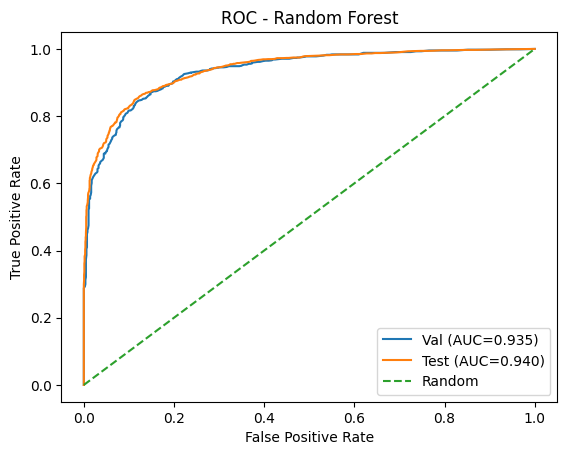

In [9]:
def eval_model(name, model, Xv, yv, Xt, yt):
    pv = model.predict_proba(Xv)[:, 1]
    pt = model.predict_proba(Xt)[:, 1]

    yv_pred = (pv >= 0.5).astype(int)
    yt_pred = (pt >= 0.5).astype(int)

    out = {}
    out["val_cm"] = confusion_matrix(yv, yv_pred)
    out["val_precision"] = precision_score(yv, yv_pred, zero_division=0)
    out["val_recall"] = recall_score(yv, yv_pred, zero_division=0)
    out["val_auc"] = roc_auc_score(yv, pv)

    out["test_cm"] = confusion_matrix(yt, yt_pred)
    out["test_precision"] = precision_score(yt, yt_pred, zero_division=0)
    out["test_recall"] = recall_score(yt, yt_pred, zero_division=0)
    out["test_auc"] = roc_auc_score(yt, pt)

    print(f"\n===== {name} =====")
    print("VAL  - precision:", round(out["val_precision"], 4), "recall:", round(out["val_recall"], 4), "AUC:", round(out["val_auc"], 4))
    print("VAL  - CM:\n", out["val_cm"])
    print("TEST - precision:", round(out["test_precision"], 4), "recall:", round(out["test_recall"], 4), "AUC:", round(out["test_auc"], 4))
    print("TEST - CM:\n", out["test_cm"])

    fpr_v, tpr_v, _ = roc_curve(yv, pv)
    fpr_t, tpr_t, _ = roc_curve(yt, pt)

    plt.figure()
    plt.plot(fpr_v, tpr_v, label=f"Val (AUC={out['val_auc']:.3f})")
    plt.plot(fpr_t, tpr_t, label=f"Test (AUC={out['test_auc']:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {name}")
    plt.legend()
    plt.show()

    return out

log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])
log_reg.fit(X_train_sel, y_train)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_sel, y_train)

res_lr = eval_model("Logistic Regression", log_reg, X_val_sel, y_val, X_test_sel, y_test)
res_rf = eval_model("Random Forest", rf, X_val_sel, y_val, X_test_sel, y_test)


## Resultados de modelos (resumen)

Con los features de la URL entrené dos modelos: Logistic Regression y Random Forest.  
En general, Random Forest se comportó mejor tanto en validación como en prueba.

- **Logistic Regression (TEST):** precision = 0.8301, recall = 0.7526, AUC = 0.8895  
- **Random Forest (TEST):** precision = 0.8713, recall = 0.8611, AUC = 0.9399  

Por eso usé Random Forest como el modelo principal para el análisis final.

## 4) ¿Qué impacto tiene marcar un dominio legítimo como phishing (falso positivo)?

El impacto principal es que se bloquea o se alerta sobre un enlace que en realidad era seguro.  
Eso puede causar molestia al usuario, pérdida de tiempo y también que la gente deje de confiar en el sistema si pasa muy seguido (porque “todo lo marca como phishing”).

## 5) ¿Qué impacto tiene marcar phishing como legítimo (falso negativo)?

Este es el caso más delicado, porque significa que un enlace malicioso “se cuela” como si fuera seguro.  
En la práctica esto puede terminar en robo de credenciales, acceso no autorizado o infección, dependiendo del tipo de phishing.

## 6) ¿Qué métrica es mejor para comparar modelos en este problema? ¿Por qué?

Yo le daría prioridad al **recall** (especialmente para la clase phishing), porque en seguridad es más grave dejar pasar un ataque que generar una alerta de más.  
Igual, para comparar de forma más general también usé **AUC**, porque resume qué tan bien separa las dos clases sin depender de un solo umbral.

## 7) ¿Qué modelo funcionó mejor y por qué?

El que funcionó mejor fue **Random Forest**, porque obtuvo mejores números en prueba:
- mayor **AUC** (0.9399 vs 0.8895),
- mejor **recall** (0.8611 vs 0.7526),
- y también mejor **precision** (0.8713 vs 0.8301).

En otras palabras, detecta más phishing y al mismo tiempo se equivoca menos que Logistic.

## 8) Base rate (50,000 correos, 15% phishing)

Para Random Forest en test, la matriz de confusión fue:
TN = 1497, FP = 218, FN = 238, TP = 1476

Con eso:
- **TPR (recall)** ≈ 0.8611
- **FPR** ≈ 218 / (218 + 1497) ≈ 0.1271

Si entran **50,000 correos** y **15% son phishing**:
- Phishing reales: 7,500
- Legítimos reales: 42,500

Estimación:
- **TP** ≈ 0.8611 * 7,500 ≈ 6,458
- **FN** ≈ 7,500 - 6,458 ≈ 1,042
- **FP** ≈ 0.1271 * 42,500 ≈ 5,402
- **TN** ≈ 42,500 - 5,402 ≈ 37,098

Esto significa que el sistema levantaría alrededor de **11,860 alertas** (TP + FP).  
Funciona para detectar bastante phishing, pero todavía genera varias alertas falsas. Si se quisiera bajar FP, se podría ajustar el umbral (no usar 0.5 fijo) o aplicar una segunda validación para los casos dudosos.


###Base Rate (50,000 emails; 15% phishing)
Calculamos valores esperados con:
- **TPR = Recall**
- **FPR** desde la matriz de confusión


In [10]:
def base_rate_estimate(cm, tpr, total_emails=50000, phishing_rate=0.15):
    tn, fp = cm[0,0], cm[0,1]
    fn, tp = cm[1,0], cm[1,1]
    fpr = fp / (fp + tn) if (fp + tn) else 0.0

    phishing = total_emails * phishing_rate
    legit = total_emails - phishing

    exp_tp = tpr * phishing
    exp_fn = phishing - exp_tp
    exp_fp = fpr * legit
    exp_tn = legit - exp_fp

    return {
        "FPR": fpr,
        "TPR/Recall": tpr,
        "Expected_TP": exp_tp,
        "Expected_FN": exp_fn,
        "Expected_FP": exp_fp,
        "Expected_TN": exp_tn,
        "Expected_Alerts": exp_tp + exp_fp,
        "Expected_Pred_Legit": exp_tn + exp_fn
    }

chosen = res_rf  # Cambia a res_lr si quieres
cm_test = chosen["test_cm"]
tpr_test = chosen["test_recall"]

est = base_rate_estimate(cm_test, tpr_test, total_emails=50000, phishing_rate=0.15)
pd.DataFrame([est]).T.rename(columns={0:"valor"})


,valor
FPR,0.127114
TPR/Recall,0.861144
Expected_TP,6458.576429
Expected_FN,1041.423571
Expected_FP,5402.332362
Expected_TN,37097.667638
Expected_Alerts,11860.908791
Expected_Pred_Legit,38139.091209


**Responde:**
- Con este base rate, ¿el sistema “sirve” o produce demasiadas falsas alarmas?
- ¿Qué harías para reducir FP sin perder demasiado recall? (ej. cambiar umbral, PR curve, etc.)

**Con este **base rate (15% phishing)** el sistema **sí sirve** porque logra detectar la mayoría de correos phishing (**TP ≈ 6459** de 7500).  
El problema es que todavía genera bastantes alertas falsas (**FP ≈ 5402**), o sea que de unas **11861 alertas** totales, casi la mitad serían falsas. Entonces funciona como filtro, pero si se usa tal cual podría cansar al usuario o al equipo que revisa alertas.

Para **reducir falsos positivos sin perder demasiado recall**, haría esto:
- **Ajustar el umbral** (no usar 0.5 fijo). Subirlo un poco puede bajar bastante los FP, aunque se pierda algo de recall.
- Elegir el umbral usando una **curva Precision–Recall** para buscar un mejor balance según lo que se quiera priorizar.
- Usar un enfoque en **dos pasos**: el modelo marca “sospechosos” y luego solo esos casos pasan por una segunda revisión (por ejemplo reputación del dominio o reglas simples).
- (Opcional) Probar **class weights** o calibración de probabilidades para que el modelo sea más “conservador” al lanzar alertas.**
